In [ ]:
# -*- coding: utf-8 -*-

"""
This software is part of GPU Ocean. 
Copyright (C) 2019 SINTEF Digital

This notebook shows the individual steps of the Stochastic Ensemble
Kalman Filter for an ocean ensemble.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""


import sys, os, datetime, time, shutil
from importlib import reload 
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec as gridspec

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

current_dir = os.getcwd()

if os.path.isdir(os.path.abspath(os.path.join(current_dir, '../../SWESimulators'))):
        sys.path.insert(0, os.path.abspath(os.path.join(current_dir, '../../')))

from SWESimulators import IPythonMagic
from SWESimulators import BaseOceanStateEnsemble, OceanNoiseEnsemble, CDKLM16 
from SWESimulators import Common
from SWESimulators import DataAssimilationUtils as dautils



In [ ]:
%cuda_context_handler gpu_ctx
%setup_logging --out enkf_gpu.log --file_level 15

Registering gpu_ctx in user workspace
Global logger already initialized!


# Set up an instance 

OceanNoiseEnsemble using CDKLM16-Simulators

In [ ]:
# DEFINE PARAMETERS

sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 60, "ny": 60,
    "dx": 4.0, "dy": 4.0,
    "dt": 0.05,
    "g": 9.81,
    "f": 0.05,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "rk_order": 2,
    "small_scale_perturbation_amplitude": None,
    "write_netcdf": False, 
    "small_scale_perturbation": True,
    "small_scale_perturbation_interpolation_factor": 3,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}

ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])


dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
dataShapeHi = (sim_args["ny"] + ghosts[0]+ghosts[2]+1, 
             sim_args["nx"] + ghosts[1]+ghosts[3]+1)

sim_args["eta0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hv0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hu0"] = np.zeros(dataShape, dtype=np.float32, order='C');
waterDepth = 10.0
sim_args["H"] = np.ones(dataShapeHi, dtype=np.float32, order='C')*waterDepth


if 'sim' in globals():
    sim.cleanUp()
if 'ensemble' in globals():
    ensemble.cleanUp()
if 'iewpfOcean' in globals():
    iewpfOcean.cleanUp()
    
sim_args["small_scale_perturbation_amplitude"] = np.sqrt(sim_args["dt"])*0.5*sim_args["f"]/(sim_args["g"]*waterDepth)
sim_args["small_scale_perturbation_amplitude"] *= sim_args["small_scale_perturbation_interpolation_factor"]
print ("q0: ", sim_args["small_scale_perturbation_amplitude"])
print ("[f, g, H, dt]", [sim_args["f"], sim_args["g"], waterDepth, sim_args["dt"]])
print ("(nx, ny): ", (sim_args["nx"], sim_args["ny"]))

reload(CDKLM16)
reload(BaseOceanStateEnsemble)
reload(OceanNoiseEnsemble)
reload(dautils)

sim = CDKLM16.CDKLM16(**sim_args)
sim.perturbState(q0_scale=100)
    
ensemble_args = {
    "gpu_ctx": gpu_ctx,
    "numParticles": 100,
    "num_drifters": 1,
    "sim": sim,
    "observation_type": dautils.ObservationType.StaticBuoys,
    "buoys_positions" : [[120.0,120.0]],
    "observation_variance": 0.5**2,
    "initialization_variance_factor_ocean_field" : 25.0
}

ensemble = OceanNoiseEnsemble.OceanNoiseEnsemble(**ensemble_args)

max_dt = ensemble.findLargestPossibleTimeStep()
print ("max_dt: ", max_dt)

print ("Ready!")

q0:  0.00017095320928897472
[f, g, H, dt] [0.05, 9.81, 10.0, 0.05]
(nx, ny):  (60, 60)
max_dt:  0.08935757726430893
Ready!


# Run Simulation until Observation Time

In [ ]:
t = 100*sim_args["dt"]
ensemble.step(t)

print("Ready!")

Ready!


# Book keeping

In [ ]:
# Deactivating some particles for testing
ensemble.particlesActive[2]=False
ensemble.particlesActive[7]=False

In [ ]:
# Size of ensemble
N_e = ensemble.getNumParticles()
N_e_active = ensemble.getNumActiveParticles()

# Number of observers
N_d = ensemble.getNumDrifters()

# particle properties before EnKF analysis phase
observedParticles_pre = ensemble.observeParticles()
innovationNorms_pre = ensemble.getInnovationNorms()

# rmse values before EnKF analysis phase
ensemble.getEnsembleVarAndRMSEUnderDrifter(t)
rmse_eta_pre = ensemble.rmseUnderDrifter_eta
rmse_hu_pre  = ensemble.rmseUnderDrifter_hu
rmse_hv_pre  = ensemble.rmseUnderDrifter_hv


# Step-By-Step EnKF in Square Root Formulation

In [ ]:
def deleteDeactivatedObservations(observation, ensemble):
    """
    Delete inactive particles
    """
    idx = 0
    for p in range(ensemble.getNumParticles()):
        if ensemble.particlesActive[p]:
            idx+=1
        elif not ensemble.particlesActive[p]:
            observation = np.delete(observation, idx, axis=0)
    return observation

## Calculate $S = H X'_f$

In [ ]:
"""
Particles are observed in the following form:
[
particle 1:  [hu_1, hv_1], ... , [hu_D, hv_D],
...
particle Ne: [hu_1, hv_1], ... , [hu_D, hv_D]
]

In order to bring it in accordance with later data structure we use the following format for the storage of the perturbation of the observation:
[
[hu_1 (particle 1), ..., hu_1 (particle Ne)],
...
[hu_D (particle 1), ..., hu_D (particle Ne)],
[hv_1 (particle 1), ..., hv_1 (particle Ne)],
...
[hv_D (particle 1), ..., hv_D (particle Ne)],
]

"""

# Observation 
HX_f_orig = ensemble.observeParticles()

HX_f_orig = deleteDeactivatedObservations(HX_f_orig, ensemble)

# Reshaping
HX_f = np.zeros( (2*N_d, N_e_active) )
for e in range(N_e_active):
    for l in range(N_d):
        HX_f[l,e]     = HX_f_orig[e,l,0]
    for l in range(N_d):
        HX_f[N_d+l,e] = HX_f_orig[e,l,1]

HX_f_mean = np.sum(HX_f, axis=1)

HX_f_pert = HX_f - HX_f_mean.reshape((2*N_d,1))



## Calculate $SS^\top = HPH^\top$ 

In [ ]:

HPHT = 1/(N_e_active-1) * np.dot(HX_f_pert,HX_f_pert.T)


## Calculate $F = HPH^\top + R$

In [ ]:
R_orig = ensemble.getObservationCov()

R = np.zeros( (R_orig.shape[0]*N_d, R_orig.shape[1]*N_d) )

for l in range(N_d):
    R[l,l] = R_orig[0,0]
    R[N_d+l, N_d+l] = R_orig[1,1]
    R[l,N_d+l] = R_orig[0,1]
    R[N_d+l,l] = R_orig[1,0]

F = HPHT + R

### Comparison of Cov for error of observing the state ($HPH^\top$) and Cov for error of observation ($R$)

In [ ]:
print("R = \n", R, "\nand HPHT = \n", HPHT)

R = 
 [[0.25 0.  ]
 [0.   0.25]] 
and HPHT = 
 [[ 1.67410838e+05 -1.42312619e+03]
 [-1.42312619e+03  1.28464601e+01]]


## Calculate Innovation $D = Y - HX_f$ 
## and perturb $D=D+Y'$

In [ ]:
"""
Particles yield innovations in the following form:
[
particle 1:  [hu_1, hv_1], ... , [hu_D, hv_D],
...
particle Ne: [hu_1, hv_1], ... , [hu_D, hv_D]
]

In order to bring it in accordance with later data structure we use the following format for the storage of the perturbation of the observation:
[
[d_hu_1 (particle 1), ..., d_hu_1 (particle Ne)],
...
[d_hu_D (particle 1), ..., d_hu_D (particle Ne)],
[d_hv_1 (particle 1), ..., d_hv_1 (particle Ne)],
...
[d_hv_D (particle 1), ..., d_hv_D (particle Ne)],
]

"""

innovation_orig = ensemble.getInnovations()[:,:,:]

innovation_orig = deleteDeactivatedObservations(innovation_orig, ensemble)

# Reshaping
innovation = np.zeros( (2*N_d, N_e_active) )
for e in range(N_e_active):
    for l in range(N_d):
        innovation[l,e]     = innovation_orig[e,l,0]
    for l in range(N_d):
        innovation[N_d+l,e] = innovation_orig[e,l,1]

Y_pert = np.random.multivariate_normal(np.zeros(2*N_d),R ,N_e_active).T

D = innovation + Y_pert


## Calculate $C = F^{-1}D$

In [ ]:
Finv = np.linalg.inv(F)
C = np.dot(Finv,D)

## Calculate $E=S^\top C$


In [ ]:
E = np.dot(HX_f_pert.T,C)

## Calculate $X'_f = X_f - \overline{X_f}$ 

In [ ]:
"""
The download gives eta = 
[
[eta(x0,y0),...,eta(xN,y0)],
...,
[eta(x0,yN),...,eta(xN,yN)]
]
as an array of size Ny x Nx
and analog for hu and hv.
we use those as an 1D array eta = 
[eta(x0,y0),...,eta(xN,y0),eta(x0,y1),...,eta(xN,y(N-1)),eta(x0,yN),...,eta(xN,yN)]
and anlog for hu and hv 

For further calculations the indivdual dimensions of the state variable are concatinated X = 
[eta, hu, hv]

Collecting the state perturbation for each ensemble member in a matrix Nx x Ne, where
X_f_pert = 
[ 
[eta_pert(x0,y0) (particle 1),..., eta_pert],
...
particle 2: [eta_pert,hu_pert,hv_pert]
]
"""

# Ghost cells added 
n_i = ensemble.particles[0].ny + 4 
n_j = ensemble.particles[0].nx + 4

X_f = np.zeros((3*n_i*n_j, N_e_active))
idx = 0
for e in range(N_e):
    if ensemble.particlesActive[e]:
        eta, hu, hv = ensemble.particles[e].download(interior_domain_only=False)
        eta = eta.reshape(n_i*n_j)
        hu  = hu.reshape(n_i*n_j)
        hv  = hv.reshape(n_i*n_j)
        X_f[:,idx] = np.append(eta, np.append(hu,hv))
        idx += 1

X_f_mean = np.zeros( 3*n_i*n_j )
for e in range(N_e_active):
    X_f_mean += 1/N_e_active * X_f[:,e]

X_f_pert = np.zeros_like( X_f )
for e in range(N_e_active):
    X_f_pert[:,e] = X_f[:,e] - X_f_mean
 

## Calculate $X_a$


In [ ]:
X_a = X_f + 1/(N_e_active-1) * np.dot(X_f_pert,E)

## Reshape and upload analysis state

In [ ]:
idx = 0
for e in range(N_e):
    if ensemble.particlesActive[e]:
        eta = X_a[0:n_i*n_j, idx].reshape((n_i,n_j))
        hu  = X_a[n_i*n_j:2*n_i*n_j, idx].reshape((n_i,n_j))
        hv  = X_a[2*n_i*n_j:3*n_i*n_j, idx].reshape((n_i,n_j))
        ensemble.particles[e].upload(eta,hu,hv)
        idx += 1


# Plotting Utils

In [ ]:
def _fillPolarPlot(ax, ensemble, observedParticles, alpha, printInfo=False):
    """
    Internal utility function for plotting current under a drifter as a polar plot.
    """
    max_r = 0
    observedParticlesSingleDrifter = observedParticles[:, 0, :]
    if printInfo: print("observedParticlesSingleDrifter: \n" +str(observedParticlesSingleDrifter))
    for p in range(ensemble.getNumParticles()):
        u, v = observedParticlesSingleDrifter[p,0], observedParticlesSingleDrifter[p,1]
        r = np.sqrt(u**2 + v**2)
        max_r = max(max_r, r)
        theta = np.arctan(v/u)
        if (u < 0):
            theta += np.pi
        arr1 = plt.arrow(theta, 0, 0, r, alpha = alpha, \
                         length_includes_head=True, \
                         edgecolor = 'green', facecolor = 'green', zorder = 5)

    obs_u = ensemble.observeTrueState()[0, 2]
    obs_v = ensemble.observeTrueState()[0, 3]
    if printInfo: print("observedTrueState: " + str((obs_u, obs_v)))
    obs_r = np.sqrt(obs_u**2 + obs_v**2)
    max_r = max(max_r, obs_r)
    obs_theta = np.arctan(obs_v/obs_u)
    if (obs_u < 0):
        obs_theta += np.pi
    arr1 = plt.arrow(obs_theta, 0, 0, obs_r, alpha = 0.5,\
                     length_includes_head=True, \
                     edgecolor = 'red', facecolor = 'red', zorder = 5)

    ax.set_rmax(max_r*1.2)
    plt.grid(True)
    plt.title("Momentum observations from drifter")


def _fillHistPlot(ax, ensemble, innovationNorms, alpha, printInfo=False):
    if printInfo: print("innovation norms: " + str(innovationNorms))
    obs_var = ensemble.getObservationVariance()
    range_x = np.sqrt(obs_var)*10
    ax.hist(innovationNorms, bins=30, facecolor='green', \
                range=(0, range_x), alpha=alpha,\
                density=True, label="particle innovations (norm)")
    plt.title("Innovation norms from drifter")


def plotVelocityInfoBeforeAndAfterDA(ensemble, observedParticles, innovationNorms, observedParticles_pre=None, innovationNorms_pre=None, title=None) :

    # Initialize File
    fig = None
    plotRows = 2
    fig = plt.figure(figsize=(10,6))
    gridspec.GridSpec(plotRows, 3)

    # PLOT POSITIONS OF PARTICLES AND OBSERVATIONS
    ax = plt.subplot2grid((plotRows,3), (0,0), polar=True)
    _fillPolarPlot(ax, ensemble, observedParticles, 0.5, printInfo=False)
    if observedParticles_pre is not None:
        _fillPolarPlot(ax, ensemble, observedParticles_pre, 0.1, printInfo=False)

    # PLOT DISCTRIBUTION OF PARTICLE DISTANCES AND THEORETIC OBSERVATION PDF
    ax0 = plt.subplot2grid((plotRows,3), (0,1), colspan=2)
    _fillHistPlot(ax0, ensemble, innovationNorms, 0.5, printInfo=False)
    if innovationNorms_pre is not None:
        _fillHistPlot(ax0, ensemble, innovationNorms_pre, 0.1, printInfo=False)

    if title is not None:
        plt.suptitle(title, fontsize=16)
    plt.tight_layout()

# ------------------------------------------------------------------------

def _fillHistComponentPlot(ax, ensemble, observedParticles, component, alpha, markTruth=False, subtitle=None):
    true_component = ensemble.observeTrueState()[0,2+component]
    range_x = 5
    ax.hist(observedParticles[:,0][:,component], bins=50, facecolor='green', \
        range=(true_component-range_x,true_component+range_x), \
        alpha=alpha, density=True)
    if markTruth is True:
        ax.axvline(true_component, color='green', linestyle='dashed', linewidth=1)
    if subtitle is not None:
        ax.title.set_text(subtitle)


def plotVelocityComponentInfoBeforeAndAfterDA(ensemble, observedParticles, observedParticles_pre=None, title=None):
    fig = None
    fig, axs = plt.subplots(1, 2, figsize=(10,3))
    # hist for hu
    subtitle = "$hu$ distribution for ensemble"
    _fillHistComponentPlot(axs[0], ensemble, observedParticles, 0, 0.5, markTruth=True, subtitle=subtitle)
    if observedParticles_pre is not None:
        _fillHistComponentPlot(axs[0], ensemble, observedParticles_pre, 0, 0.1)
    # hist for hv
    subtitle = "$hv$ distribution for ensemble"
    _fillHistComponentPlot(axs[1], ensemble, observedParticles, 1, 0.5, markTruth=True, subtitle=subtitle)
    if observedParticles_pre is not None:
        _fillHistComponentPlot(axs[1], ensemble, observedParticles_pre, 1, 0.1)



# Plot circular diagram and histogram

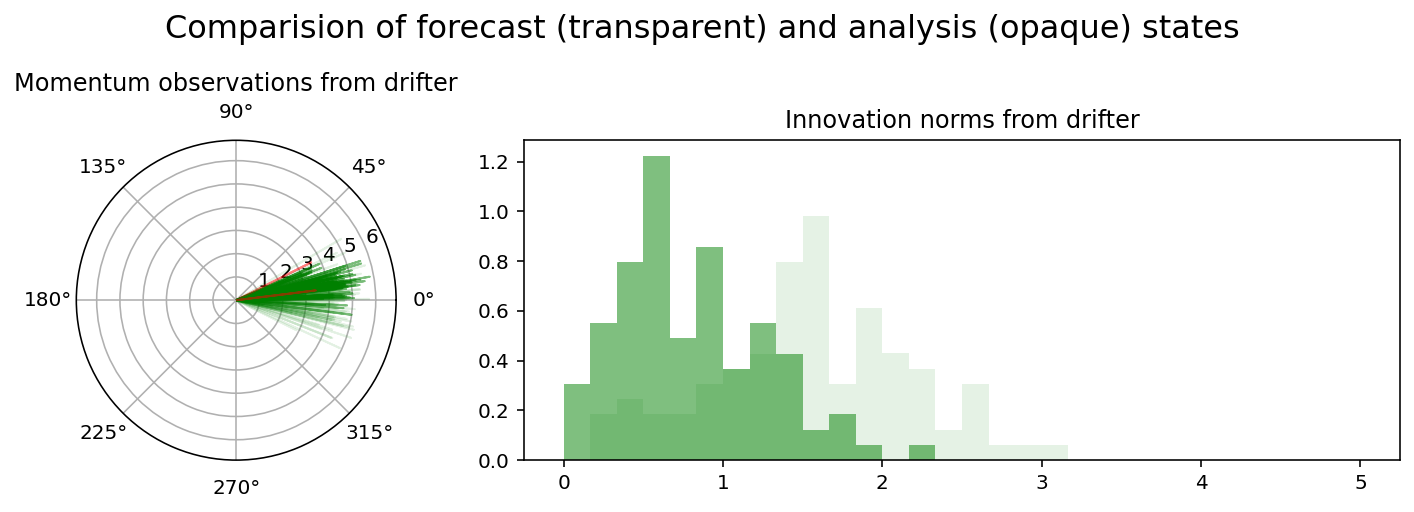

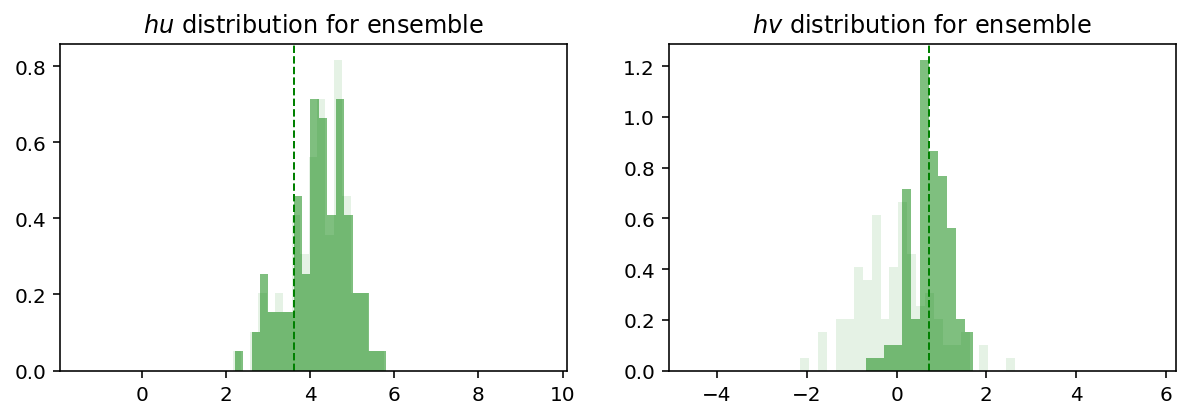

In [ ]:
# Download Data from Simulators
observedParticles = ensemble.observeParticles()
innovationNorms = ensemble.getInnovationNorms()

title = "Comparision of forecast (transparent) and analysis (opaque) states"
plotVelocityInfoBeforeAndAfterDA(ensemble, observedParticles, innovationNorms, observedParticles_pre, innovationNorms_pre, title)

title = "Comparision of forecast (transparent) and analysis (opaque) states for velocity components"
plotVelocityComponentInfoBeforeAndAfterDA(ensemble, observedParticles, observedParticles_pre, title)

## Compare norms of particles before and after assimilation 

In [ ]:
for e in range(N_e):
    norm_pre = np.sqrt(np.sum(observedParticles_pre[e,:]**2))
    norm = np.sqrt(np.sum(observedParticles[e,:]**2))
    print("norm before EnKF: ", format(norm_pre, ".6f"), " and norm after EnKF: ", format(norm, ".6f"))

norm before EnKF:  3.808519  and norm after EnKF:  3.734724
norm before EnKF:  3.686267  and norm after EnKF:  3.574806
norm before EnKF:  nan  and norm after EnKF:  nan
norm before EnKF:  3.639196  and norm after EnKF:  3.777007
norm before EnKF:  5.219169  and norm after EnKF:  4.627472
norm before EnKF:  4.711745  and norm after EnKF:  4.616313
norm before EnKF:  4.040381  and norm after EnKF:  4.154706
norm before EnKF:  nan  and norm after EnKF:  nan
norm before EnKF:  4.431635  and norm after EnKF:  4.177494
norm before EnKF:  4.267593  and norm after EnKF:  4.371366
norm before EnKF:  4.319000  and norm after EnKF:  4.383681
norm before EnKF:  4.368675  and norm after EnKF:  4.501434
norm before EnKF:  4.387079  and norm after EnKF:  4.434464
norm before EnKF:  5.082236  and norm after EnKF:  4.672857
norm before EnKF:  3.351342  and norm after EnKF:  3.419215
norm before EnKF:  4.629029  and norm after EnKF:  4.619653
norm before EnKF:  4.689552  and norm after EnKF:  4.847407


# RMSE Analysis

In [ ]:
# rmse values before EnKF analysis phase
ensemble.getEnsembleVarAndRMSEUnderDrifter(t)
rmse_eta = ensemble.rmseUnderDrifter_eta
rmse_hu  = ensemble.rmseUnderDrifter_hu
rmse_hv  = ensemble.rmseUnderDrifter_hv

In [ ]:
print("Comparison of RMSE before and after analysis phase\n")
print("RMSE for eta before: ", rmse_eta[0], " and after: ", rmse_eta[1])
print("RMSE for hu  before: ", rmse_hu[0], " and after: ", rmse_hu[1])
print("RMSE for hv  before: ", rmse_hv[0], " and after: ", rmse_hv[1])

Comparison of RMSE before and after analysis phase

RMSE for eta before:  0.012636176583585403  and after:  0.012466168329764172
RMSE for hu  before:  0.8299410981440832  and after:  0.8412637157104297
RMSE for hv  before:  1.2299831513035946  and after:  0.49931343224710417
